# Modèle SVM pour détecter les risques de cancer cervical
par Binh Minh TRAN

## 1. Télechargement des packages nécessaires

In [1]:
# 1. Manipulation des données
import numpy as np
import pandas as pd

# 2. Sérialisation des objets Python
import pickle

# 3. Visualisation des données
import matplotlib.pyplot as plt
import seaborn as sns

# 4. Prétraitement des données
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 5. Modélisation
from sklearn import svm
from sklearn.svm import SVC

# 6. Évaluation du modèle (Model Evaluation)
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, roc_auc_score, confusion_matrix

# 7. Validation croisée et recherche de paramètres
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# 8. Traitement des étiquettes
from sklearn.preprocessing import label_binarize

# 9. Outils supplémentaires
from collections import Counter

# 10. Fonctions personnalisées
from fonctionUtile import * 

## 2. Importation des ensembles d'entraînement et de test (validation croisée)

In [2]:
with open('variables.pkl', 'rb') as f:
    (fold_indices, df, 
                 X_train_1, Y_train_1, X_train_2, Y_train_2, 
                 X_train_3, Y_train_3, X_train_4, Y_train_4, 
                 X_train_5, Y_train_5,  
                 X_test_1, Y_test_1, X_test_2, Y_test_2, 
                 X_test_3, Y_test_3, X_test_4, Y_test_4,
                 X_test_5, Y_test_5, ) = pickle.load(f)

In [3]:
list_X_train = [X_train_1, X_train_2, X_train_3, X_train_4, X_train_5]
list_Y_train = [Y_train_1, Y_train_2, Y_train_3, Y_train_4, Y_train_5]
list_X_test = [X_test_1, X_test_2, X_test_3, X_test_4, X_test_5]
list_Y_test = [Y_test_1, Y_test_2, Y_test_3, Y_test_4, Y_test_5]

## 3. Vérification de la séparation linéaire avec SVM

Avec 19 attributs, on ne peut pas visualiser, donc on effectue une PCA pour projeter l'ensemble d'entraînement dans un espace à 2 dimensions et effectuer un SVM avec un noyau linéaire. On applique la PCA pour déterminer si nous devons utiliser un noyau non linéaire pour le SVM.

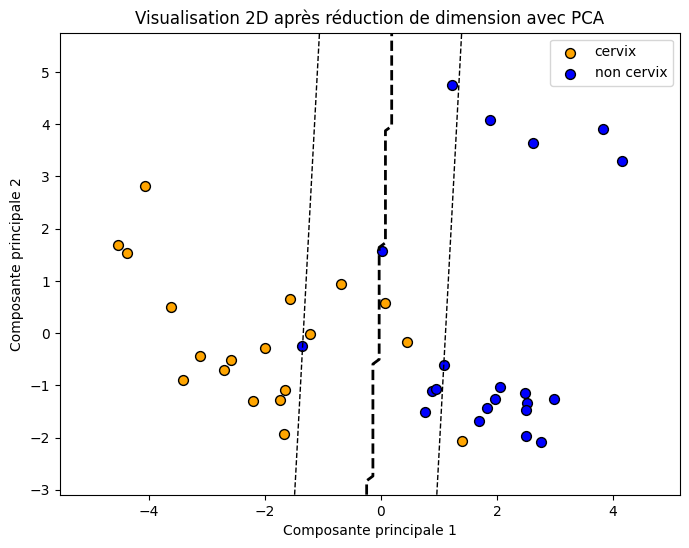

In [4]:
pca_et_visualisation(X_train_1, Y_train_1)

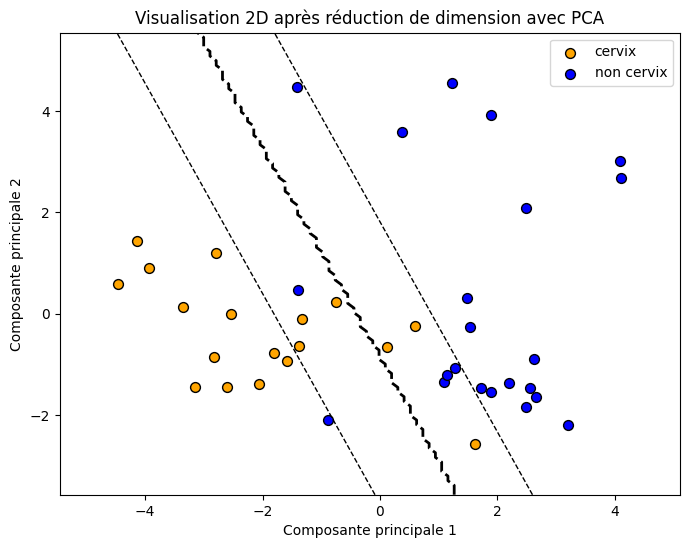

In [5]:
pca_et_visualisation(X_train_2, Y_train_2)

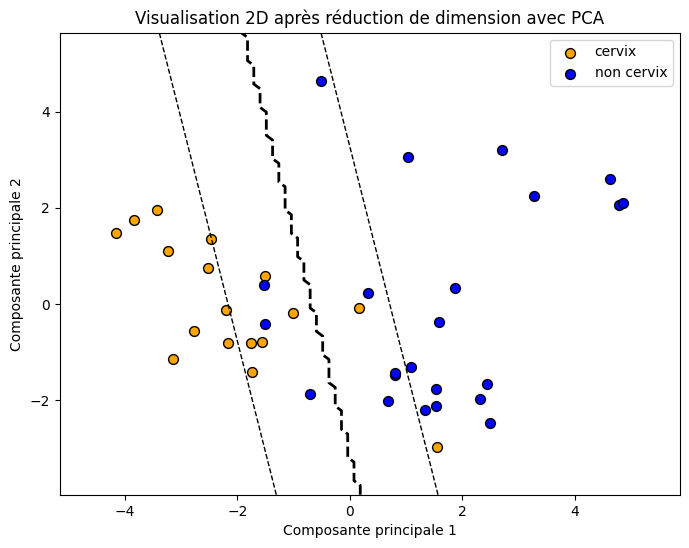

In [6]:
pca_et_visualisation(X_train_3, Y_train_3)

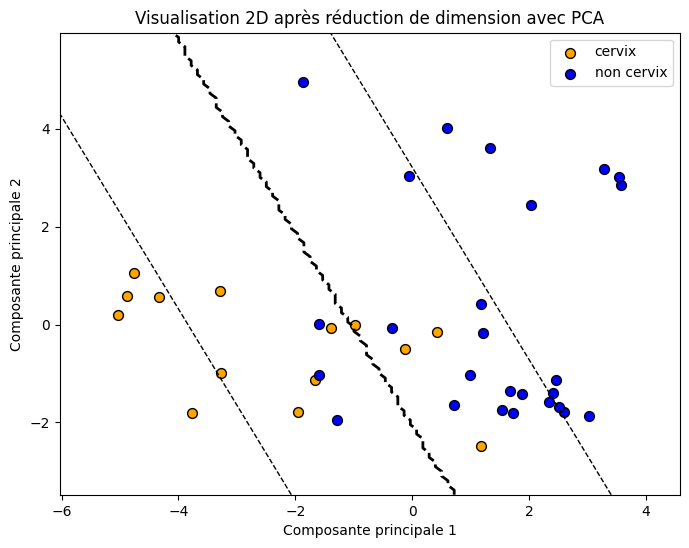

In [7]:
pca_et_visualisation(X_train_4, Y_train_4)

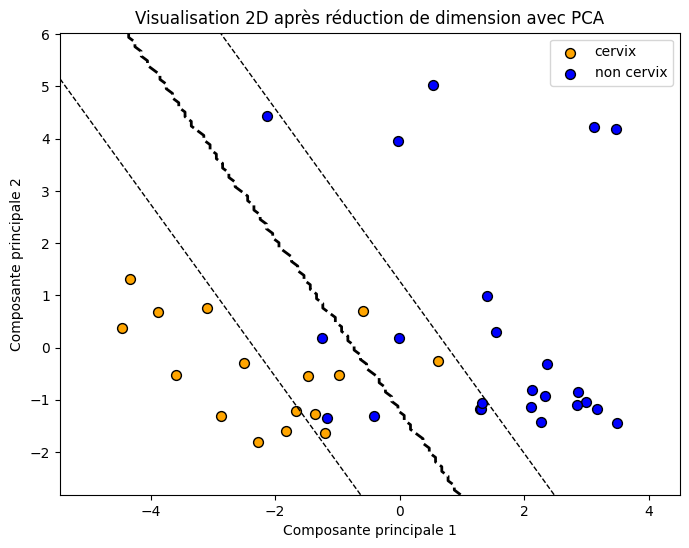

In [8]:
pca_et_visualisation(X_train_5, Y_train_5)

On peut évidemment observer la séparation linéaire dans les 5 ensembles d'entraînement, mais elle n'est pas clairement définie. Cependant, nous allons tout de même essayer d'entraîner le modèle avec un noyau linéaire.

## 4. SVM

### 4.1 Optimisation des hyperparamètres de SVM avec Cross-Validation

L'algorithme SVM possède un paramètre C qui doit être optimisé, mais la taille de l'ensemble de données est réduite (72 individus). Par conséquent, la recherche du paramètre C optimal en divisant simplement l'ensemble en ensembles d'entraînement et de test risquerait de provoquer un surapprentissage (overfitting). C'est pourquoi nous utilisons la validation croisée pour déterminer la valeur optimale de C.

In [9]:
scores = []
f1_scores = []
best_C_values = []

# Boucle sur les 5 plis (folds)
for i in range(5):
    X_train, X_test = list_X_train[i], list_X_test[i]
    y_train, y_test = list_Y_train[i], list_Y_test[i]
    
    # Normalisation des données
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train) 
    X_test_scaled = scaler.transform(X_test)        
    
    # Réduction de dimension avec PCA pour conserver 90% de la variance
    pca = PCA(n_components=0.9)  # Conserver 90 % de la variance
    X_train_pca = pca.fit_transform(X_train_scaled)  
    X_test_pca = pca.transform(X_test_scaled)        
    
    # Initialisation du modèle SVC avec noyau linéaire
    svc = SVC(kernel='linear')  # Noyau linear
    
    # Définir la grille de paramètres à rechercher
    param_grid = {
        'C': [0.01, 0.1, 1.5, 1, 2,3, 10, 100, 1000]  # Différentes valeurs de C
    } 
    
    # Recherche par grille avec validation croisée (5 plis externes)
    grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train_pca, y_train)  

    # Récupérer la meilleure valeur de C et le meilleur modèle
    best_C = grid_search.best_params_['C']
    best_model = grid_search.best_estimator_
    best_C_values.append(best_C)  # Stocker la meilleure valeur de C
    
    # Prédiction sur les données de test
    y_pred = best_model.predict(X_test_pca)
    
    # Calculer les scores
    score = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Stocker les résultats
    scores.append(score)
    f1_scores.append(f1)
    
    # Afficher les résultats pour chaque pli
    print(f"Fold {i+1}: Meilleure valeur de C = {best_C}, Précision = {score}, F1-score = {f1}")

# Résultats globaux
print("\nPrécision moyenne sur tous les plis:", np.mean(scores))
print("F1-score moyen sur tous les plis:", np.mean(f1_scores))
print("Meilleures valeurs de C pour chaque pli:", best_C_values)

Fold 1: Meilleure valeur de C = 0.01, Précision = 0.8, F1-score = 0.6666666666666666
Fold 2: Meilleure valeur de C = 1.5, Précision = 0.8, F1-score = 0.6666666666666666
Fold 3: Meilleure valeur de C = 0.01, Précision = 0.8, F1-score = 0.6666666666666666
Fold 4: Meilleure valeur de C = 0.01, Précision = 0.8, F1-score = 0.8333333333333334
Fold 5: Meilleure valeur de C = 1.5, Précision = 0.8, F1-score = 0.75

Précision moyenne sur tous les plis: 0.8
F1-score moyen sur tous les plis: 0.7166666666666667
Meilleures valeurs de C pour chaque pli: [0.01, 1.5, 0.01, 0.01, 1.5]


Après l'entraînement sur 5 plis, nous pouvons choisir C = 0.01 comme les meilleures valeurs de C pour le modèle final avec noyau lineaire


In [10]:
scores = []
f1_scores = []
best_C_values_rbf = []

# Boucle sur les 5 plis (folds)
for i in range(5):
    X_train, X_test = list_X_train[i], list_X_test[i]
    y_train, y_test = list_Y_train[i], list_Y_test[i]
    
    # Normalisation des données
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train) 
    X_test_scaled = scaler.transform(X_test)        
    
    # Réduction de dimension avec PCA pour conserver 90% de la variance
    pca = PCA(n_components=0.9)  # Conserver 90 % de la variance
    X_train_pca = pca.fit_transform(X_train_scaled)  
    X_test_pca = pca.transform(X_test_scaled)        
    
    # Initialisation du modèle SVC avec noyau phi tuyến tính (RBF)
    svc = SVC(kernel='rbf')  # Noyau RBF phi tuyến tính
    
    # Définir la grille de paramètres à rechercher
    param_grid = {
        'C': [0.01, 0.1, 1.5, 1, 2 ,3, 10, 100,1000]  # Différentes valeurs de C
    } 
    
    # Recherche par grille avec validation croisée (5 plis externes)
    grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train_pca, y_train)  

    # Récupérer la meilleure valeur de C et le meilleur modèle
    best_C = grid_search.best_params_['C']
    best_model = grid_search.best_estimator_
    best_C_values_rbf.append(best_C)  # Stocker la meilleure valeur de C
    
    # Prédiction sur les données de test
    y_pred = best_model.predict(X_test_pca)
    
    # Calculer les scores
    score = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Stocker les résultats
    scores.append(score)
    f1_scores.append(f1)
    
    # Afficher les résultats pour chaque pli
    print(f"Fold {i+1}: Meilleure valeur de C = {best_C}, Précision = {score}, F1-score = {f1}")

# Résultats globaux
print("\nPrécision moyenne sur tous les plis:", np.mean(scores))
print("F1-score moyen sur tous les plis:", np.mean(f1_scores))
print("Meilleures valeurs de C pour chaque pli:", best_C_values_rbf)


Fold 1: Meilleure valeur de C = 10, Précision = 0.8, F1-score = 0.6666666666666666
Fold 2: Meilleure valeur de C = 1.5, Précision = 0.8, F1-score = 0.75
Fold 3: Meilleure valeur de C = 10, Précision = 1.0, F1-score = 1.0
Fold 4: Meilleure valeur de C = 1, Précision = 0.8, F1-score = 0.8333333333333334
Fold 5: Meilleure valeur de C = 3, Précision = 0.8, F1-score = 0.75

Précision moyenne sur tous les plis: 0.8400000000000001
F1-score moyen sur tous les plis: 0.8
Meilleures valeurs de C pour chaque pli: [10, 1.5, 10, 1, 3]


Nous pouvons choisir C = 10 comme la meilleure valeur de C pour le modèle final avec noyau RBF.

### 4.2 Entraînement du modèle avec le meilleur paramètre C

Après avoir trouvé la valeur optimale de C, nous divisons l'ensemble de données en un ensemble d'entraînement et un ensemble de test selon un ratio de 75/25, avec C = 1.

In [11]:
X= df.drop(["cancer_colUterus"], axis=1)
y= df["cancer_colUterus"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape)
print(X_test.shape)

(50, 19)
(22, 19)


In [12]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) 

In [13]:
svc_best_lin = SVC(C=0.01, kernel='linear', probability=True)

svc_best_lin.fit(X_train_scaled, y_train)
y_pred_lin = svc_best_lin.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred_lin)
f1 = f1_score(y_test, y_pred_lin)
conf_matrix = confusion_matrix(y_test, y_pred_lin)

print(f"Accuracy: {accuracy}")
print(f"F1-score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")

Accuracy: 0.7272727272727273
F1-score: 0.4
Confusion Matrix:
[[14  0]
 [ 6  2]]


In [14]:
svc_best_rbf = SVC(C=10, kernel='rbf', probability=True)

svc_best_rbf.fit(X_train_scaled, y_train)

y_pred_rbf = svc_best_rbf.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred_rbf)
f1 = f1_score(y_test, y_pred_rbf)
conf_matrix = confusion_matrix(y_test, y_pred_rbf)

print(f"Accuracy: {accuracy}")
print(f"F1-score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")

Accuracy: 1.0
F1-score: 1.0
Confusion Matrix:
[[14  0]
 [ 0  8]]


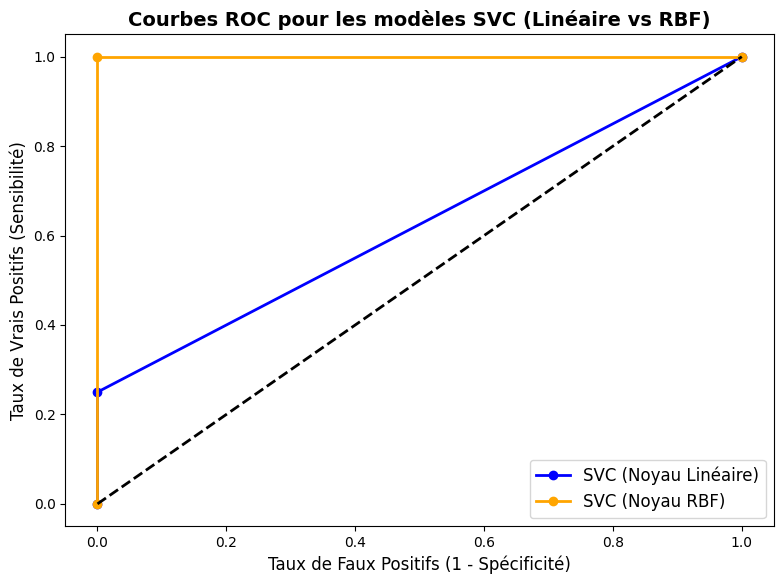

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Calcul des courbes ROC
fpr_lin, tpr_lin, _ = roc_curve(y_test, y_pred_lin)  # ROC pour le modèle SVC avec noyau linéaire
fpr_rbf, tpr_rbf, _ = roc_curve(y_test, y_pred_rbf)  # ROC pour le modèle SVC avec noyau RBF

plt.figure(figsize=(8, 6))

plt.plot(fpr_lin, tpr_lin, label='SVC (Noyau Linéaire)', linewidth=2, marker='o', markersize=6, markerfacecolor='blue', color='blue')
plt.plot(fpr_rbf, tpr_rbf, label='SVC (Noyau RBF)', linewidth=2, marker='o', markersize=6, markerfacecolor='orange', color='orange')

# Tracer la ligne diagonale (modèle aléatoire avec AUC = 0.5)
plt.plot([0, 1], [0, 1], 'k--', linewidth=2)

plt.rcParams['font.size'] = 12
plt.title('Courbes ROC pour les modèles SVC (Linéaire vs RBF)', fontsize=14, fontweight='bold')

plt.xlabel('Taux de Faux Positifs (1 - Spécificité)', fontsize=12)
plt.ylabel('Taux de Vrais Positifs (Sensibilité)', fontsize=12)

plt.legend(loc='lower right', fontsize=12)

# Afficher le graphique
plt.tight_layout()
plt.savefig("../Image/ROC_SVM.png")
plt.show()

#### Critique 

Nous pouvons conclure qu'avec cet ensemble de données, le modèle SVM avec noyau RBF donne de meilleurs résultats en termes de précision (accuracy), F1-score, courbe ROC, et AUC = 1. Nous allons utiliser ce modèle avec noyau RBF pour le comparer avec d'autres modèles tels que Naive Bayes, Decision Tree, ou Logistic Regression.

## 5. Exporter les variables

In [16]:
roc_data_rbf = {
    'fpr_rbf': fpr_rbf,
    'tpr_rbf': tpr_rbf
}

with open('roc_data_rbf.pkl', 'wb') as file:
    pickle.dump(roc_data_rbf, file)
print("Les données ont été enregistrées avec succès dans 'roc_data_rbf.pkl'.")

Les données ont été enregistrées avec succès dans 'roc_data_rbf.pkl'.
